In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from pathlib import Path
import logging
from scipy.stats import norm  # For critical z-values

In [3]:
import os
import pandas as pd

# Define the folders and metrics
folders = ['Steal', 'Nifty']
metrics = ['MSAS', 'AWD', 'TC']

# Initialize a dictionary to hold the data for each metric
data = {metric: [] for metric in metrics}

# Iterate over each folder
for folder in folders:
    # Construct the path to the folder
    folder_path = os.path.join(f"./{folder}/Evaluation/")
    
    # Read the f1.csv file
    f1_df = pd.read_csv(os.path.join(folder_path, 'f1.csv'))
    
    # Iterate over each metric
    for metric in metrics:
        # Read the metric file
        metric_df = pd.read_csv(os.path.join(folder_path, f'{metric}.csv'))
        
        # Merge the f1 and metric dataframes on 'Epochs'
        merged_df = pd.merge(f1_df, metric_df, on='Epochs')
        
        # Add the 'UC' column
        merged_df['UC'] = folder
        
        # Rename columns to match the desired format
        merged_df.rename(columns={metric: 'Metric', 'f1': 'f1'}, inplace=True)
        
        # Select the relevant columns
        merged_df = merged_df[['UC', 'Epochs', 'f1', 'Metric']]
        
        # Append the data to the corresponding metric list
        data[metric].append(merged_df)

# Concatenate all dataframes for each metric and write to CSV
for metric in metrics:
    combined_df = pd.concat(data[metric])
    combined_df.to_csv(f'{metric}_output.csv', index=False)

print("Files have been created successfully.")

Files have been created successfully.


In [4]:
def calculate_spearman_ci(correlation: float, n: int, confidence_level: float = 0.95):
    """
    Calculate the confidence interval for a Spearman correlation coefficient using Fisher's z-transformation.

    Args:
        correlation (float): Spearman correlation coefficient.
        n (int): Sample size.
        confidence_level (float): Confidence level for the interval (default: 0.95).

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """
    if n <= 3:
        raise ValueError("Sample size must be greater than 3 to calculate confidence interval.")

    # Fisher's z-transformation
    z = np.arctanh(correlation)
    se_z = 1 / np.sqrt(n - 3)  # Standard error of z

    # Critical value for the confidence level
    #z_critical = norm.ppf((1 + confidence_level) / 2)
    z_critical = 2.576

    # Confidence interval for z
    z_lower = z - z_critical * se_z
    z_upper = z + z_critical * se_z

    # Transform back to correlation scale
    ci_lower = np.tanh(z_lower)
    ci_upper = np.tanh(z_upper)

    return ci_lower, ci_upper

In [5]:
def save_correlation_results(correlation_results: list, evaluation_path: str):
    """
    This function attempts to save correlation results to a CSV file.

    Parameters:
    - correlation_results: List or dictionary of correlation data to be saved.
    - evaluation_path: Path where the CSV file will be saved.

    Logs a message if the results are successfully saved or if an error occurs.
    """
    try:
        results_df = pd.DataFrame(correlation_results)
        results_csv_path = f"{evaluation_path}/correlation.csv"
        results_df.to_csv(results_csv_path, index=False)
        logging.info(f"Correlation results saved to {results_csv_path}")
    except ValueError as ve:
        logging.warning(str(ve))
    except Exception as e:
        logging.error(f"An error occurred while saving the correlation results: {str(e)}")

In [6]:
def spearman_correlation(f1_ratios: np.ndarray, metric_values: np.ndarray):
    """
    Perform Spearman correlation analysis between F1-ratio and the specified metric values.

    Args:
        f1_ratios (numpy.ndarray): Path to the F1-ratios CSV.
        metric_values (numpy.ndarray): Metric column name (e.g., "AWD").

    Returns:
        tuple: Spearman correlation coefficient, p-value, and merged DataFrame.
    """
    try:
        correlation, p_value = spearmanr(f1_ratios, metric_values)
        return correlation, p_value
    except Exception as e:
        logging.error(f"Error calculating correlation for: {e}")
        return None, None

In [7]:
def plot_correlation(X: np.ndarray, Y: np.ndarray, corr: float, plot_path: str, metric_name: str, epochs: np.ndarray, uc: np.ndarray):
    """
    Plot the scatter plot of two variables and display the Spearman correlation.
    Annotate each data point with its corresponding epoch number and color by use case.

    Args:
        X (np.ndarray): First variable (e.g., "F1-ratio").
        Y (np.ndarray): Second variable (e.g., metric values).
        corr (float): Spearman correlation coefficient.
        plot_path (str): Directory to save the correlation plot.
        metric_name (str): Name of the metric being analyzed.
        epochs (np.ndarray): Array of epoch numbers corresponding to the data points.
        uc (np.ndarray): Array of use cases corresponding to the data points.
    """
    try:
        plt.figure(figsize=(10, 8))  # Slightly larger figure for better readability
        
        # Scatter plot with hue for use case (UC)
        sns.scatterplot(x=X, y=Y, hue=uc, s=60, marker='o', edgecolor="black")
        
        # Regression line
        sns.regplot(x=X, y=Y, scatter=False, color="green", line_kws={"lw": 3, "ls": "--"}, ci=None)

        # Annotate each point with its epoch number
        for i, epoch in enumerate(epochs):
            plt.text(X[i], Y[i], f'E{epoch}', fontsize=9, ha='right', va='bottom', color='black')

        # Display Spearman correlation
        plt.text(0.05, 0.85, f"Spearman Correlation: {corr:.2f}", transform=plt.gca().transAxes,
                 fontsize=14, color="red", bbox=dict(facecolor='white', alpha=0.5))

        plt.xlabel("F1-ratio", fontsize=14)
        plt.ylabel(f"{metric_name} (score)", fontsize=14)
        plt.grid(visible=True, linestyle="--", alpha=0.7)
        plt.title(f"Correlation between F1-ratio and {metric_name}", fontsize=16, fontweight="bold")

        # Add legend for use cases
        plt.legend(title="Use Case", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Save the plot
        output_path = f"{plot_path}/{metric_name}.png"
        plt.savefig(output_path, bbox_inches="tight")
        logging.info(f"Plot saved to {output_path}")
    except Exception as e:
        logging.error(f"Error plotting correlation for {metric_name}: {e}")

Spearman correlation for AWD_output.csv: -0.099, p-value: 0.589
95% Confidence Interval for AWD_output.csv: (-0.521, 0.362)
Spearman correlation for MSAS_output.csv: -0.516, p-value: 0.003
95% Confidence Interval for MSAS_output.csv: (-0.781, -0.092)
Spearman correlation for TC_output.csv: -0.826, p-value: 0.000
95% Confidence Interval for TC_output.csv: (-0.929, -0.602)


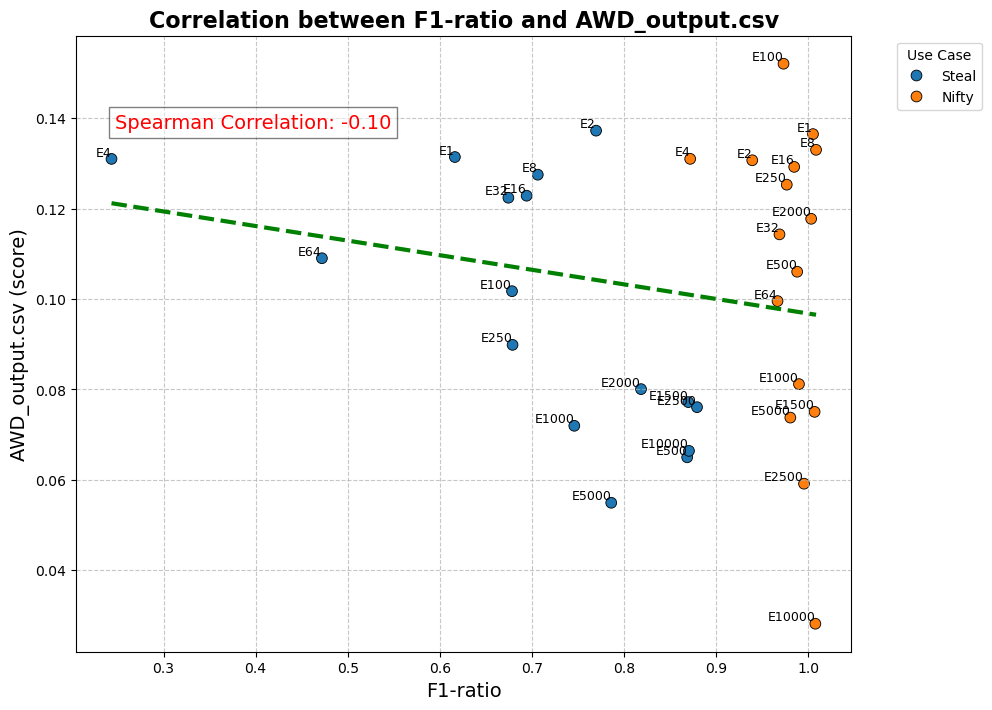

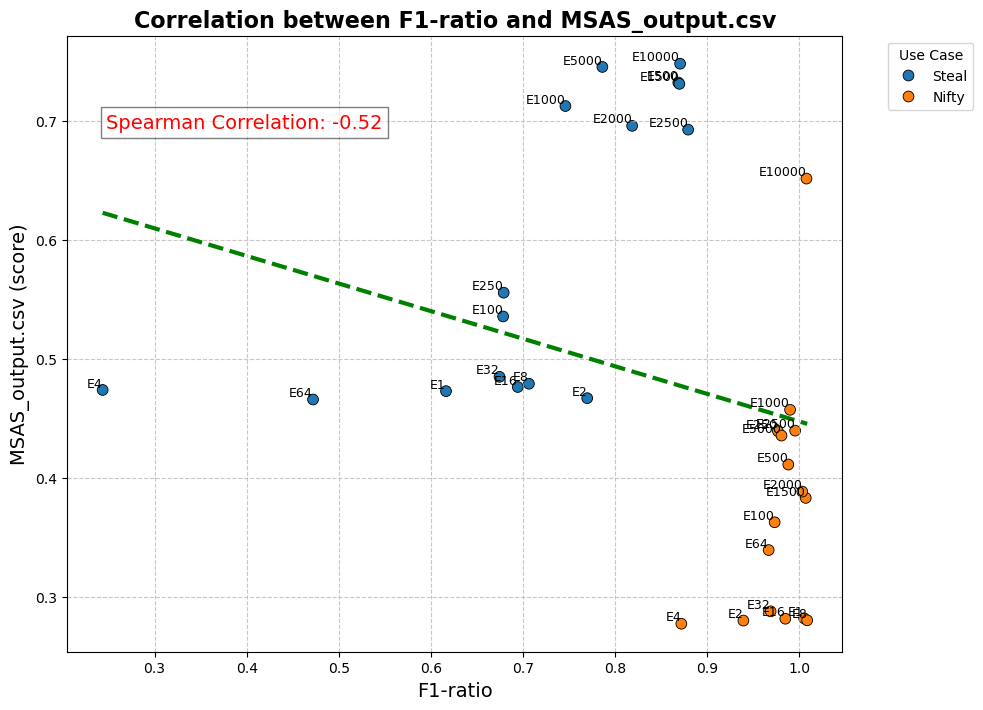

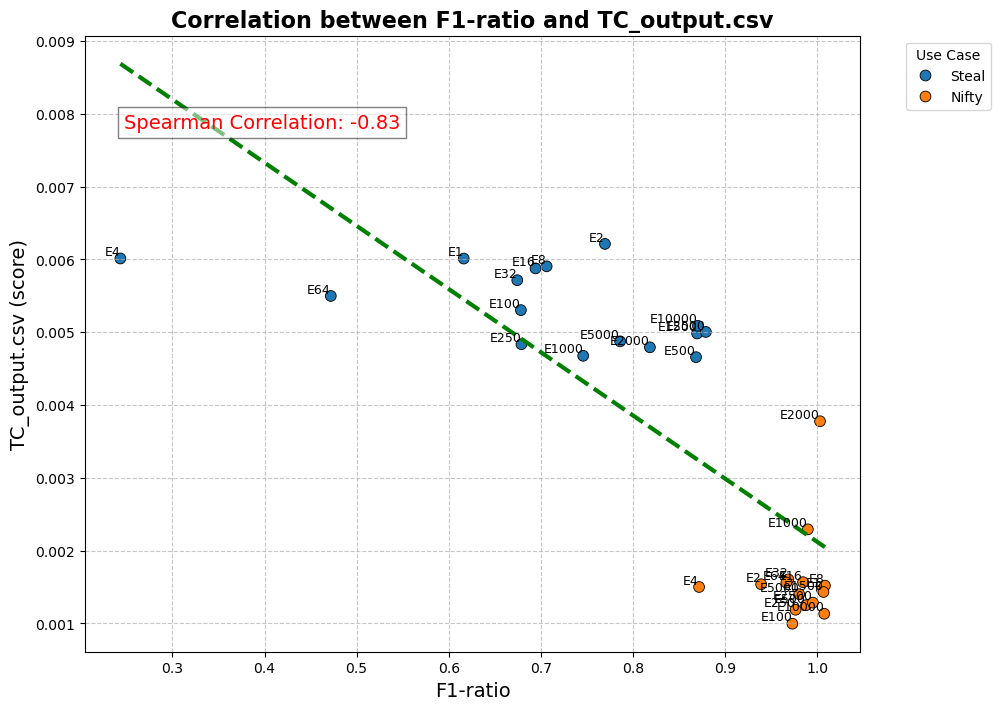

In [8]:
metric_files = ["AWD_output.csv", "MSAS_output.csv", "TC_output.csv"]
correlation_results = []

for file in metric_files:
    data = pd.read_csv(file)
    f1 = data['f1']
    metric = data['Metric']
    epoch = data['Epochs']
    uc = data['UC']
    correlation, p_value = spearman_correlation(f1, metric)
    print(f"Spearman correlation for {file}: {correlation:.3f}, p-value: {p_value:.3f}")
    if correlation is not None and p_value is not None:
        ci_lower, ci_upper = calculate_spearman_ci(correlation, len(f1), confidence_level=0.99)
        print(f"95% Confidence Interval for {file}: ({ci_lower:.3f}, {ci_upper:.3f})")
        correlation_results.append({
            "metric": file,
            "correlation": correlation,
            "p_value": p_value,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        })
        
        # Plot correlation with epoch annotations
        plot_correlation(
            X=f1,
            Y=metric,
            corr=correlation,
            plot_path='./',
            metric_name=file,
            epochs=epoch,
            uc = uc
        )

    save_correlation_results(correlation_results, '.')